In [1]:
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import time
import random
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('TWTR.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,32.700001,33.430000,32.599998,33.419998,33.419998,13407500
1,2018-05-24,33.439999,33.759998,33.119999,33.520000,33.520000,14491900
2,2018-05-25,33.540001,33.990002,33.310001,33.630001,33.630001,10424400
3,2018-05-29,33.419998,34.830002,33.349998,34.040001,34.040001,22086700
4,2018-05-30,34.200001,34.660000,34.080002,34.360001,34.360001,14588200


In [3]:
parameters = [df['Close'].tolist(), df['Volume'].tolist()]

## Global parameters

In [4]:
window_size = 20
skip = 1
layer_size = 500
output_size = 3

In [5]:
def get_state(parameters, t, window_size = 20):
    outside = []
    d = t - window_size + 1
    for parameter in parameters:
        block = parameter[d : t + 1] if d >= 0 else -d * [parameter[0]] + parameter[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        for i in range(1, window_size, 1):
            res.append(block[i] - block[0])
        outside.append(res)
    return np.array(outside).reshape((1, -1))

Our output size from `get_state` is 38. In this notebook, I only use `Close` and `Volume` parameters, you can choose any parameters you want from your DataFrame.

After that, I want to add another parameters, my `inventory` size, mean of `inventory` and `capital`.

Let say for an example,
```
inventory_size = 1
mean_inventory = 0.5
capital = 2
last_state = 0
```

We have 3 actions,

1. `0` for do nothing.
2. `1` for buy.
3. `2` for sell.

In [6]:
inventory_size = 1
mean_inventory = 0.5
capital = 2
concat_parameters = np.concatenate([get_state(parameters, 20), [[inventory_size, 
                                                                mean_inventory,
                                                                capital]]], axis = 1)

In [7]:
input_size = concat_parameters.shape[1]
input_size

79

In [8]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
    
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        
class Model:
    
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [9]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, timeseries, skip, initial_money, real_trend):
        self.model = model
        self.timeseries = timeseries
        self.skip = skip
        self.real_trend = real_trend
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self._initiate()
        
        
    def _initiate(self):
        # i assume first index is the close value
        self.trend = self.timeseries[0]
        self._mean = np.mean(self.trend)
        self._std = np.std(self.trend)
        self._inventory = []
        self._capital = self.initial_money
        self._queue = []
        self._min = np.min(self.real_trend)
        self._max = np.max(self.real_trend)
        self._scaled_capital = self._scale(self._capital)
    
    def reset_capital(self, capital):
        if capital:
            self._capital = capital
        self._scaled_capital = self._scale(self._capital)
        self._queue = []
        self._inventory = []
        
    def _scale(self, data):
        std = (data - self._min) / (self._max - self._min)
        return std * 100 + 100
    
    def _reverse_scale(self, data):
        std = (data - 100) / 100
        return (std * (self._max - self._min)) + self._min
        
    def trade(self, data):
        """
        you need to make sure the data is [close, volume]
        """
        scaled_data = [self._scale(d) for d in data]
        real_close = data[0]
        close = scaled_data[0]
        if len(self._queue) > window_size:
            self._queue.pop(0)
        self._queue.append(scaled_data)
        if len(self._queue) < window_size:
            return {'status': 'data not enough to trade', 'action': 'fail',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        state = self.get_state(window_size - 1, 
                       self._inventory,
                       self._scaled_capital,
                       timeseries = np.array(self._queue).T.tolist())
        action = self.act(state)
        if action == 1 and self._scaled_capital >= close:
            self._inventory.append(close)
            self._scaled_capital -= close
            self._capital -= real_close
            return {'status': 'buy 1 unit, cost %f'%(real_close),
                    'action': 'buy',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        elif action == 2 and len(self._inventory):
            bought_price = self._inventory.pop(0)
            self._scaled_capital += close
            self._capital += real_close
            scaled_bought_price = self._reverse_scale(bought_price)
            try:
                invest = ((real_close - scaled_bought_price) / scaled_bought_price) * 100
            except:
                invest = 0
            return {'status': 'sell 1 unit, price %f'%(real_close),
                    'investment': '%f %%'%(invest),
                    'balance': self._capital,
                    'action': 'sell', 
                    'timestamp': str(datetime.now())}
        else:
            return {'status': 'do nothing', 'action': 'nothing',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        
            
    
    def change_data(self, timeseries, skip, initial_money, real_trend):
        self.timeseries = timeseries
        self.skip = skip
        self.initial_money = initial_money
        self.real_trend = real_trend
        self._initiate()
    
    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t, inventory, capital, timeseries):
        state = get_state(timeseries, t)
        len_inventory = len(inventory)
        if len_inventory:
            mean_inventory = np.mean(inventory)
        else:
            mean_inventory = 0
        z_inventory = (mean_inventory - self._mean) / self._std
        z_capital = (capital - self._mean) / self._std
        concat_parameters = np.concatenate([state, [[len_inventory,
                                                     z_inventory,
                                                     z_capital]]], axis = 1)
        return concat_parameters
        
    
    def get_reward(self, weights):
        initial_money = self._scaled_capital
        starting_money = initial_money
        self.model.weights = weights
        inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= self.trend[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = self.get_state(t + 1, inventory, starting_money, self.timeseries)
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)
        
    def buy(self):
        initial_money = self._scaled_capital
        starting_money = initial_money
        
        real_initial_money = self.initial_money
        real_starting_money = self.initial_money
        inventory = []
        real_inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                real_inventory.append(self.real_trend[t])
                real_starting_money -= self.real_trend[t]
                starting_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.real_trend[t], 
                                                                           real_starting_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                real_bought_price = real_inventory.pop(0)
                starting_money += self.trend[t]
                real_starting_money += self.real_trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.real_trend[t] - real_bought_price) / real_bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.real_trend[t], invest, real_starting_money)
                )
            state = self.get_state(t + 1, inventory, starting_money, self.timeseries)
        
        invest = ((real_starting_money - real_initial_money) / real_initial_money) * 100
        total_gains = real_starting_money - real_initial_money
        return states_buy, states_sell, total_gains, invest

In [10]:
stocks = [i for i in os.listdir(os.getcwd()) if '.csv' in i and not 'AMD' in i]
stocks

['TWTR.csv',
 'GOOG.csv',
 'FB.csv',
 'LB.csv',
 'MTDR.csv',
 'CPRT.csv',
 'FSV.csv',
 'TSLA.csv',
 'SINA.csv',
 'GWR.csv']

In [11]:
model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
df = pd.read_csv('TWTR.csv')
real_trend = df['Close'].tolist()
stock_mean = df['Close'].mean()
stock_std = df['Close'].std()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
scaled_parameters = MinMaxScaler(feature_range = (100, 200)).fit_transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2
agent = Agent(model = model,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      real_trend = real_trend)

In [12]:
volume = df['Volume'].tolist()

In [13]:
for i in range(40):
    print(agent.trade([real_trend[i], volume[i]]))

{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131623'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131802'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131825'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131845'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131863'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131881'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-05-25 19:39:16.131899'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'ti

In [14]:
states_buy, states_sell, total_gains, invest = agent.buy()

I want to train on all stocks I downloaded except for AMD. I want to use AMD for testing.

In [15]:
model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
agent = None

for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    df = pd.read_csv(stock)
    real_trend = df['Close'].tolist()
    stock_mean = df['Close'].mean()
    stock_std = df['Close'].std()
    parameters = [df['Close'].tolist(), df['Volume'].tolist()]
    scaled_parameters = MinMaxScaler(feature_range = (100, 200)).fit_transform(np.array(parameters).T).T.tolist()
    initial_money = np.max(parameters[0]) * 2
    
    if no == 0:
        agent = Agent(model = model,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      real_trend = real_trend)
    else:
        agent.change_data(timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend)
    
    agent.fit(iterations = 500, checkpoint = 20)
    print()

training stock TWTR.csv
iter 20. reward: 2.632184
iter 40. reward: 49.027243
iter 60. reward: 92.607000
iter 80. reward: 112.851899
iter 100. reward: 132.879372
iter 120. reward: 157.679094
iter 140. reward: 163.538564
iter 160. reward: 166.983288
iter 180. reward: 164.442672
iter 200. reward: 175.291854
iter 220. reward: 184.424363
iter 240. reward: 207.587563
iter 260. reward: 211.593059
iter 280. reward: 210.494422
iter 300. reward: 210.379972
iter 320. reward: 211.226849
iter 340. reward: 216.891758
iter 360. reward: 211.238292
iter 380. reward: 211.249731
iter 400. reward: 219.867259
iter 420. reward: 210.448636
iter 440. reward: 219.157717
iter 460. reward: 228.381796
iter 480. reward: 227.637916
iter 500. reward: 226.436280
time taken to train: 144.892569065094 seconds

training stock GOOG.csv
iter 20. reward: -57.126598
iter 40. reward: -50.370064
iter 60. reward: 1.120791
iter 80. reward: 18.752568
iter 100. reward: 60.291605
iter 120. reward: 72.638344
iter 140. reward: 81.87

In [19]:
df = pd.read_csv('AMD.csv')
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
scaled_parameters = MinMaxScaler(feature_range = (100, 200)).fit_transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2
    
agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend)

In [20]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 21: buy 1 unit at price 15.800000, total balance 49.640002
day 22, sell 1 unit at price 15.110000, investment -4.367089 %, total balance 64.750002,
day 23: buy 1 unit at price 15.500000, total balance 49.250002
day 24: buy 1 unit at price 14.970000, total balance 34.280002
day 25: buy 1 unit at price 15.310000, total balance 18.970002
day 38, sell 1 unit at price 16.850000, investment 8.709677 %, total balance 35.820002,
day 40, sell 1 unit at price 16.500000, investment 10.220441 %, total balance 52.320002,
day 43, sell 1 unit at price 16.049999, investment 4.833436 %, total balance 68.370001,
day 55: buy 1 unit at price 19.059999, total balance 49.310002
day 60, sell 1 unit at price 19.770000, investment 3.725084 %, total balance 69.080002,
day 61: buy 1 unit at price 19.980000, total balance 49.100002
day 63: buy 1 unit at price 20.900000, total balance 28.200002
day 67, sell 1 unit at price 25.049999, investment 25.375370 %, total balance 53.250001,
day 68, sell 1 unit at price

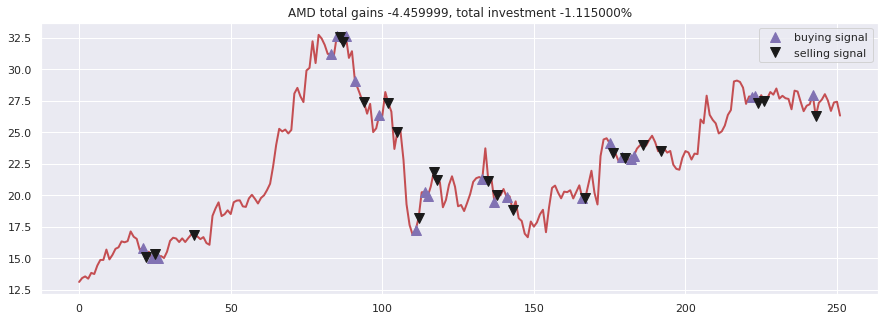

In [18]:
fig = plt.figure(figsize = (15, 5))
plt.plot(real_trend, color='r', lw=2.)
plt.plot(real_trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(real_trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('AMD total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()